#### In this notebook, input structure files are first cleaned or formatted for featurization and then featurized.

#### Import some required libraries

In [1]:

## Standard libraries
import numpy as np
import pandas as pd
import os

## For some analysis
import MDAnalysis as mda
from MDAnalysis.analysis import distances

## For plotting
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec

## For visualization
import nglview as nv

## For some data pre-processing
import sklearn.preprocessing as preprocessing

from io import StringIO


#### Global matplot font settings

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#### Read given isomer structures and create a MD universe for some visualization and data analysis

In [3]:

print('Creating a MD analysis universe from the given structure') 
isomers_universe = mda.Universe("data/isomers.xyz")

print('Universe created.')

print(f'Number of structures in the given file: {isomers_universe.trajectory.n_frames}')
      

Creating a MD analysis universe from the given structure
Universe created.
Number of structures in the given file: 6095


#### Visualize the structures using nglview

In [5]:


view = nv.show_mdanalysis(isomers_universe)

# clear representations
view.clear_representations()

# set represetnation style
view.add_representation('spacefill', radius=1)#, color='blue')
#view.add_representation('line')

view.center()

view

NGLWidget(max_frame=6094)

#### Read each structure in the given file and create a new file by keeping the ordering of atom names same in all frames. This makes distance/similarity calculation in featurization space easy.

In [6]:


# clean xyz file i.e., ensure atoms in all frames are in the same order 
# (any order; doesn't matter as long as they are the same)

frames = []
# Open the XYZ file and read each frame
with open('./data/isomers.xyz', 'r') as f:
    
    lines = f.readlines()
    
    num_atoms = int(lines[0].strip())
    
    num_lines_per_frame = num_atoms + 2  # +2 is header and blank line
    num_frames = len(lines) // num_lines_per_frame

    for i in range(num_frames):
        
        start_index = i * num_lines_per_frame
        end_index = start_index + num_lines_per_frame
        frame_lines = lines[start_index:end_index]

        buffer = StringIO('\n'.join(frame_lines))
        
        # Read the frame into a DataFrame
        df = pd.read_csv(
            buffer, delim_whitespace=True, header=None, skiprows=2, names=['Atom', 'X', 'Y', 'Z']
        )

        df = df.sort_values(by='Atom')

        frames.append(df)

        
# Define the path for the new XYZ file
formatted_xyz = './data/isomers_formatted.xyz'

with open(formatted_xyz, 'w') as f:
    
    for i in range(num_frames):
    
        # Write the number of atoms for the first frame
        f.write(str(len(frames[i])) + '\n')
        f.write('\n')

        # Iterate over each row (atom) in the DataFrame
        for index, row in frames[i].iterrows():
            # Write the atom name and coordinates to the file
            f.write(f"{row['Atom']} {row['X']} {row['Y']} {row['Z']}\n")


#### Create a MD analysis universe of the fixed isomer structures 

In [7]:
#### Sorted universe 

print('Creating a MD analysis universe from the given structure') 
sorted_isomers_universe = mda.Universe("data/isomers_formatted.xyz")

print('Universe created.')

print(f'Number of structures in the given file: {sorted_isomers_universe.trajectory.n_frames}')
      

Creating a MD analysis universe from the given structure
Universe created.
Number of structures in the given file: 6095


#### Visualize the formatted isomer structures using nglview; 
Caution: atom colors may not be updated correctly in nglview. Just ensure the 
relative positions of all atoms are identical to those before formatting.

In [9]:
view = nv.show_mdanalysis(sorted_isomers_universe)

# clear representations
view.clear_representations()

# set represetnation style
view.add_representation('spacefill', radius=1)# color='blue')

view.center()

view

NGLWidget(max_frame=6094)

#### Featurization using intra-molecular distances or unique pairwise distances between all atoms in sorted universe.

In [10]:
#### Featurization of x

# Get atom names
atom_names_isomer = [atom.name for atom in sorted_isomers_universe.atoms]

# Save features to memory
feature_distances_file = './data/features_intra_distances.npy'
        
if not os.path.exists(feature_distances_file):
        
    _pair_selection = isomers_universe.select_atoms('all')
    feature_distances = []

    # set lag
    lag = 1 # read all structures
    for ts in isomers_universe.trajectory[::lag]:

        # Assume all structures are provided within the unit cell; otherwise apply PBC corrections.
        _pair_dist = distances.distance_array(_pair_selection.positions, 
                                              _pair_selection.positions)

        # Keep only unique distances
        upper_diag_indices = np.triu_indices(_pair_dist.shape[0], k=1)
        feature_distances.append(_pair_dist[upper_diag_indices]) 
        
    # Save the array to disk
    np.save(feature_distances_file, np.array(feature_distances))
    
else:

    # Load arrays from disk
    feature_distances = np.load(feature_distances_file)
    

feature_distances = np.array(feature_distances)


#### Check distribution of each feature

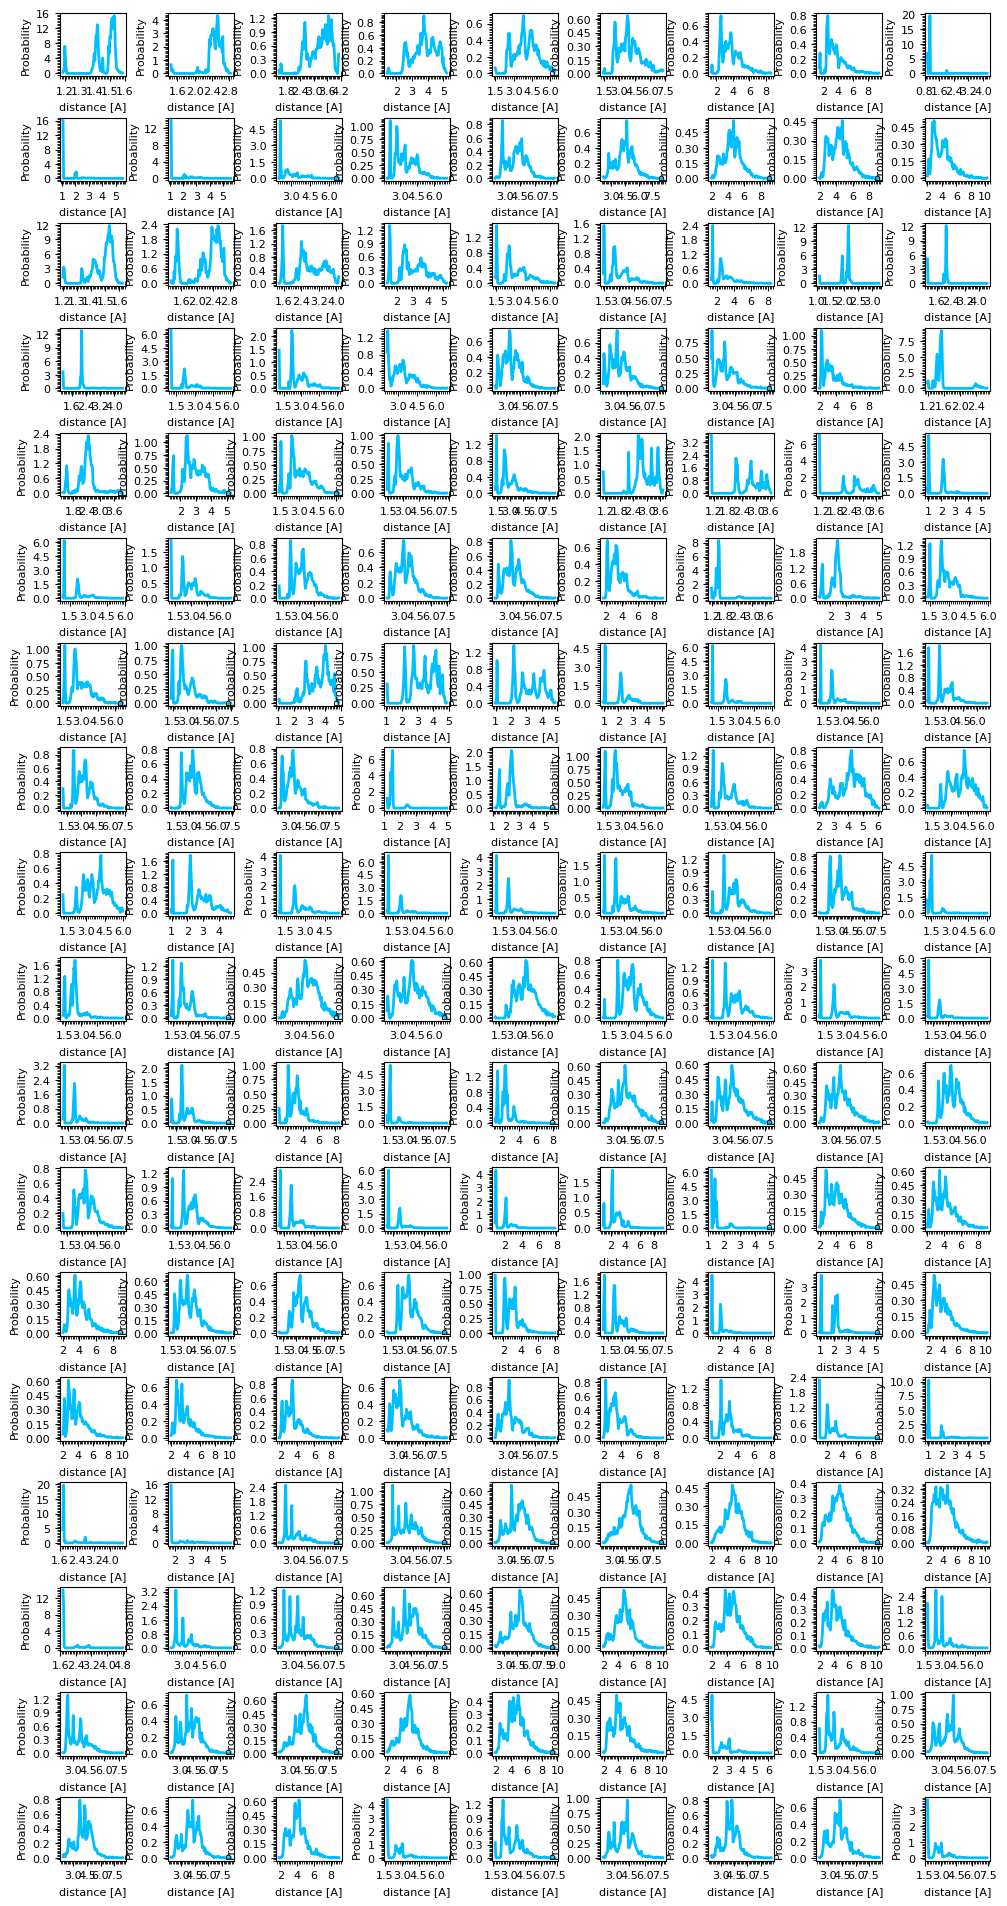

In [11]:

font = {'weight' : 'normal',
        'size'   : 8}
plt.rc('font', **font)

# check distribution of features
f, axes = plt.subplots(nrows=18, ncols=9, figsize=(12, 24), 
                       gridspec_kw={'hspace': 0.65, 'wspace': 0.65})

for ax, sf in zip(axes.flatten(), range(feature_distances.shape[-1])):
    
    # Create a histogram
    hist, bins = np.histogram(feature_distances[:,sf], bins=100, density=True)
    ax.plot(bins[:-1], hist, lw=2, color='deepskyblue');

    ax.set_xlabel(r'distance [A]')
    ax.set_ylabel('Probability')
    
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

    ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    
